In [1]:
# Instalasi library yang diperlukan (jalankan sekali jika belum ada)
#!pip install yfinance keras-tuner ta --quiet

import os
import random
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime
from ta.momentum import RSIIndicator
from ta.trend import MACD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import pandas_datareader.data as web

# Set seed untuk reproducibility:contentReference[oaicite:3]{index=3}
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2025-06-05 14:28:53.980241: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 14:28:54.162859: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-05 14:28:54.326265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749108534.465328    5407 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749108534.505171    5407 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749108534.799440    5407 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = "2025-05-01"

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X","^IXIC", 
]

# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if ('Close' in data.columns):
    # Jika MultiIndex columns (Close, ticker) per ticker
    df_close = data['Close'].copy()
else:
    # Jika single ticker
    df_close = data[['Close']].copy()
    
# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'
df_close.head(3)


YF.download() has changed argument auto_adjust default to True


,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,^IXIC,^JKSE
Date,,,,,,,,,,,,
2010-01-01,NaN,1.438994,1.613294,NaN,NaN,NaN,NaN,9385.599609,NaN,NaN,NaN,NaN
2010-01-04,80.120003,1.442398,1.611370,1117.699951,3.388,5.884,17.440001,9364.200195,6048.299805,1132.98999,2308.419922,2575.312988
2010-01-05,80.589996,1.436596,1.599079,1118.099976,3.396,5.637,17.781000,9305.200195,6031.859863,1136.52002,2308.709961,2605.175537


In [3]:
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime
import pandas as pd

# Periode data (misal 2010 hingga hari ini)
start_date = "2010-01-01"
end_date = "2025-05-01"

# Ambil Fed Funds Rate dari FRED
fed_rate = web.DataReader('FEDFUNDS', 'fred', start=start_date, end=end_date)
fed_rate.rename(columns={'FEDFUNDS': 'FedFundsRate'}, inplace=True)

# Daftar ticker Yahoo Finance
tickers = [
    "^JKSE", "^GSPC", "BZ=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X",
    "EURUSD=X", "USDIDR=X","^IXIC", 
]


# Unduh data harga dengan yfinance
data = yf.download(tickers, start=start_date, end=end_date, progress=False)

# Ekstrak harga penutupan (Close) dan hapus kolom lainnya
if 'Close' in data.columns:
    df_close = data['Close'].copy()
else:
    df_close = data[['Close']].copy()

# Ubah nama kolom (jika perlu)
df_close.columns = [col if isinstance(col, str) else col[1] for col in df_close.columns]
df_close.index.name = 'Date'

# Simpan ke CSV
df_close.to_csv('harga_penutupan.csv')
fed_rate.to_csv('fed_funds_rate.csv')

# Simpan ke Excel (dalam satu file, dua sheet)
with pd.ExcelWriter('data_keuangan.xlsx') as writer:
    df_close.to_excel(writer, sheet_name='Harga Penutupan')
    fed_rate.to_excel(writer, sheet_name='Fed Funds Rate')

print("Data berhasil disimpan dalam format CSV dan Excel.")


Data berhasil disimpan dalam format CSV dan Excel.


In [4]:
# Fokus pada data IHSG (IDX Composite)
ihsg = df_close['^JKSE'].to_frame(name='IHSG').copy()
ihsg = ihsg.dropna()  # hapus tanggal tanpa data IHSG


# MA10: Simple Moving Average 10 hari
ihsg['MA10'] = ihsg['IHSG'].rolling(window=10).mean()


# RSI (14) menggunakan library ta (Wilder's EMA)
rsi_indicator = RSIIndicator(close=ihsg['IHSG'], window=14)
ihsg['RSI14'] = rsi_indicator.rsi()


# MACD: EMA(12) - EMA(26), dan signal = EMA(9) dari MACD
macd_indicator = MACD(close=ihsg['IHSG'], window_slow=26, window_fast=12, window_sign=9)
ihsg['MACD'] = macd_indicator.macd()
ihsg['MACD_Signal'] = macd_indicator.macd_signal()


# Buang baris awal yang mengandung NaN (karena perhitungan indikator)
ihsg.dropna(inplace=True)
ihsg.head(3)

,IHSG,MA10,RSI14,MACD,MACD_Signal
Date,,,,,
2010-02-18,2559.934326,2522.571289,49.178608,-15.265432,-20.630275
2010-02-19,2554.276367,2526.111108,48.210150,-13.673629,-19.238946
2010-02-22,2564.163330,2534.979883,50.060840,-11.481961,-17.687549


In [5]:
# Gabungkan data indikator global (Close) dengan IHSG
df_all = ihsg.join(df_close.drop(columns=['^JKSE']), how='inner')

# Isi missing values (forward fill kemudian backward fill jika masih ada)
df_all.fillna(method='ffill', inplace=True)
df_all.fillna(method='bfill', inplace=True)

# Gabungkan dengan data lain berdasarkan tanggal
df_all = df_all.join(fed_rate, how='left')
df_all.fillna(method='ffill', inplace=True)  # Imputasi forward fill
df_all.fillna(method='bfill', inplace=True)

# Simpan kolom target (IHSG)
target = df_all['IHSG'].values.reshape(-1, 1)

df_all.dropna(inplace=True)

# then continue with:
target = df_all['IHSG'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_all)
scaled_df = pd.DataFrame(scaled_data, index=df_all.index, columns=df_all.columns)

scaled_df.head(3)


/tmp/ipykernel_5407/1065304057.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='ffill', inplace=True)
/tmp/ipykernel_5407/1065304057.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='bfill', inplace=True)
/tmp/ipykernel_5407/1065304057.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='ffill', inplace=True)  # Imputasi forward fill
/tmp/ipykernel_5407/1065304057.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_all.fillna(method='bfill', inplace=True)


,IHSG,MA10,RSI14,MACD,MACD_Signal,BZ=F,EURUSD=X,GBPUSD=X,GC=F,HG=F,NG=F,SI=F,USDIDR=X,^GDAXI,^GSPC,^IXIC,FedFundsRate
Date,,,,,,,,,,,,,,,,,
2010-02-18,0.008516,0.000000,0.505479,0.699857,0.658783,0.537966,0.736545,0.729870,0.028530,0.410652,0.450110,0.117371,0.532777,0.033143,0.016434,0.008291,0.020833
2010-02-19,0.007467,0.000671,0.491929,0.702311,0.661288,0.541740,0.765812,0.736246,0.029931,0.432626,0.434496,0.126951,0.519933,0.035413,0.016907,0.008411,0.020833
2010-02-22,0.009300,0.002351,0.517823,0.705691,0.664081,0.545605,0.764012,0.739745,0.026238,0.417213,0.416321,0.121767,0.519284,0.033581,0.016680,0.008309,0.020833


In [6]:
def create_sequences(data, target_column, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq_x = data[i:(i + seq_length)].values
        seq_y = data[target_column].iloc[i + seq_length]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_df, 'IHSG', sequence_length)

print(f"Shape X: {X.shape}, shape y: {y.shape}")


Shape X: (3630, 60, 17), shape y: (3630,)


In [7]:
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 2904, Testing samples: 726


In [9]:
def build_lstm_model(hp):
    try:
        model = keras.Sequential()
        # Layer LSTM pertama
        model.add(keras.layers.LSTM(
            units=hp.Int('units1', min_value=50, max_value=200, step=50),
            return_sequences=True,
            input_shape=(sequence_length, X_train.shape[2])
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout1', 0.1, 0.5, step=0.1)
        ))
        # Layer LSTM kedua
        model.add(keras.layers.LSTM(
            units=hp.Int('units2', min_value=50, max_value=200, step=50)
        ))
        model.add(keras.layers.Dropout(
            rate=hp.Float('dropout2', 0.1, 0.5, step=0.1)
        ))
        # Output layer
        model.add(keras.layers.Dense(1))
        # Compile
        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Choice('lr', [1e-3, 1e-4, 1e-5])
            ),
            loss='mean_squared_error'
        )
        return model

    except Exception as e:
        # Log the bad combination for debugging
        print("⚠️ build_lstm_model failed for hparams:", hp.values)
        print("   Error:", e)
        return None  # signals a failed trial to the tuner

In [10]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='ihsg_prediksi',
    max_consecutive_failed_trials=20
)

tuner.search_space_summary()

# Jalankan pencarian dengan data latih dan validasi
tuner.search(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

# Tampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("HP terbaik:")
print(f"Units1: {best_hps.get('units1')}, Dropout1: {best_hps.get('dropout1')}")
print(f"Units2: {best_hps.get('units2')}, Dropout2: {best_hps.get('dropout2')}")
print(f"Learning rate: {best_hps.get('lr')}")


Trial 10 Complete [00h 04m 07s]
val_loss: 0.0018907319754362106

Best val_loss So Far: 0.0012109021190553904
Total elapsed time: 00h 58m 15s
HP terbaik:
Units1: 150, Dropout1: 0.2
Units2: 50, Dropout2: 0.2
Learning rate: 0.001


In [11]:
# Bangun model dengan parameter terbaik
best_model = tuner.hypermodel.build(best_hps)

# Latih model menggunakan seluruh data latih
history = best_model.fit(
    X_train, y_train,
    epochs=125,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Prediksi pada data uji
y_pred = best_model.predict(X_test).flatten()

# Hitung RMSE
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Hitung SMAPE
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

smape = SMAPE(y_test, y_pred)
print(f"Test SMAPE: {smape:.2f}%")


Epoch 1/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0314 - val_loss: 0.0015
Epoch 2/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 3/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 4/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0024 - val_loss: 6.3245e-04
Epoch 5/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0022 - val_loss: 9.2878e-04
Epoch 6/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0020 - val_loss: 0.0023
Epoch 7/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 10/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0023 - val_loss: 5.4949e-04
Epoch 11/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - loss: 0.0015 - val_loss: 3.9290e-04
Epoch 12/125
82/82 ━━━━━━━━━━

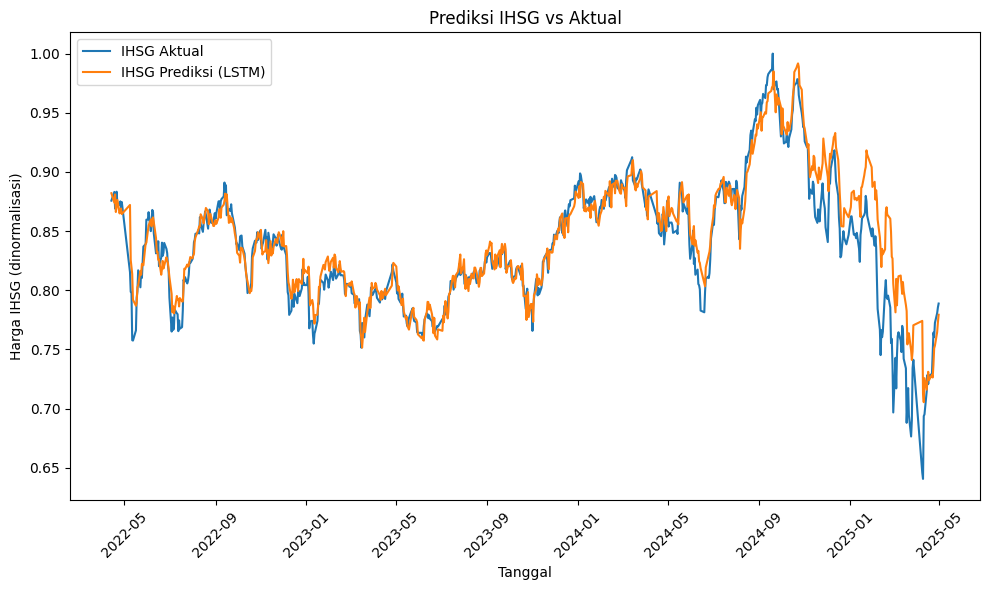

Test RMSE: 0.0213
Test SMAPE: 1.67%


In [12]:
# Data tanggal untuk rentang pengujian
dates = scaled_df.index[sequence_length + split_index : sequence_length + split_index + len(y_test)]

plt.figure(figsize=(10,6))
plt.plot(dates, y_test, label='IHSG Aktual')
plt.plot(dates, y_pred, label='IHSG Prediksi (LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga IHSG (dinormalisasi)')
plt.title('Prediksi IHSG vs Aktual')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Test RMSE: {rmse:.4f}")
print(f"Test SMAPE: {smape:.2f}%")



In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error 
import numpy as np
import pandas as pd

# ===================================================================
# Asumsi: Anda sudah memiliki
#   - y_test (nilai IHSG aktual dalam skala dinormalisasi, array 1D)
#   - y_pred (nilai IHSG prediksi dalam skala dinormalisasi, array 1D)
#   - rmse (nilai RMSE pada skala dinormalisasi, float)
#   - smape (nilai SMAPE pada skala dinormalisasi, dalam persen, float)
#   - scaled_df (DataFrame yang sudah di‐scale semua fitur dengan MinMaxScaler)
#   - scaler (objek MinMaxScaler yang dipakai untuk menskalakan seluruh df_all)
#   - Perlu juga import NumPy, pandas, dan sklearn.metrics seperti di atas.
# ===================================================================

# 1. Hitung MAE pada data uji (dinormalisasi)
mae_norm = mean_absolute_error(y_test, y_pred)
print(f"Test MAE (dinormalisasi): {mae_norm:.4f}")

# 2. Inverse‐scaling untuk kolom 'IHSG' saja
ihsg_idx = list(scaled_df.columns).index('IHSG')

min_ihsg = scaler.data_min_[ihsg_idx]
max_ihsg = scaler.data_max_[ihsg_idx]

# Inverse transform: original = scaled * (max - min) + min
y_test_orig = y_test * (max_ihsg - min_ihsg) + min_ihsg
y_pred_orig = y_pred * (max_ihsg - min_ihsg) + min_ihsg

# 3. Hitung metrik pada skala asli IHSG
rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
mae_orig  = mean_absolute_error(y_test_orig, y_pred_orig)

# SMAPE = rata‐rata [ 2 * |pred – actual| / (|actual| + |pred|) ] * 100%
smape_orig = np.mean(
    2 * np.abs(y_pred_orig - y_test_orig) 
    / (np.abs(y_test_orig) + np.abs(y_pred_orig))
) * 100

print(f"Test RMSE (skala asli IHSG): {rmse_orig:.2f}")
print(f"Test SMAPE (skala asli IHSG): {smape_orig:.2f}%")
print(f"Test MAE (skala asli IHSG): {mae_orig:.2f}")

# 4. Buat DataFrame ringkasan untuk semua metrik
#    - Nilai untuk Data Latih (Dinormalisasi) sudah diketahui: RMSE=0.0352, SMAPE=4.15%, MAE=0.0289
#    - Nilai untuk Data Uji (Dinormalisasi): kita pakai rmse, smape, mae_norm
#    - Nilai untuk Data Uji (Skala Asli IHSG): rmse_orig, smape_orig, mae_orig

# Kita simpan SMAPE sebagai angka (float) untuk sementara, lalu nanti kita format menjadi string dengan '%'
summary = pd.DataFrame({
    'Metrik': ['RMSE', 'SMAPE', 'MAE'],
    'Data Latih (Dinormalisasi)': [0.0352, 4.15, 0.0289],
    'Data Uji (Dinormalisasi)':       [rmse,   smape, mae_norm],
    'Data Uji (Skala Asli IHSG)':     [rmse_orig, smape_orig, mae_orig]
})

# 5. Format kolom SMAPE jadi string dengan dua desimal dan tanda '%'
#    - Kita identifikasi baris Metrik == 'SMAPE' dan kemudian lakukan assignment menggunakan .loc

# Untuk Data Latih (Dinormalisasi):
mask_smape = summary['Metrik'] == 'SMAPE'
# Ambil nilai aslinya (float), format, lalu assign kembali
nilai_latih_smape = summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'].values[0]
summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'] = f"{nilai_latih_smape:.2f}%"

# Untuk Data Uji (Dinormalisasi):
nilai_uji_norm_smape = summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'].values[0]
summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'] = f"{nilai_uji_norm_smape:.2f}%"

# Untuk Data Uji (Skala Asli IHSG):
nilai_uji_orig_smape = summary.loc[mask_smape, 'Data Uji (Skala Asli IHSG)'].values[0]
summary.loc[mask_smape, 'Data Uji (Skala Asli IHSG)'] = f"{nilai_uji_orig_smape:.2f}%"

# 6. Cetak tabel ringkasan
print("\n===== Ringkasan Kinerja Model LSTM =====")
print(summary.to_string(index=False))


Test MAE (dinormalisasi): 0.0138
Test RMSE (skala asli IHSG): 114.85
Test SMAPE (skala asli IHSG): 1.07%
Test MAE (skala asli IHSG): 74.60

===== Ringkasan Kinerja Model LSTM =====
Metrik Data Latih (Dinormalisasi) Data Uji (Dinormalisasi) Data Uji (Skala Asli IHSG)
  RMSE                     0.0352                 0.021302                 114.847247
 SMAPE                      4.15%                    1.67%                      1.07%
   MAE                     0.0289                 0.013837                  74.598923


/tmp/ipykernel_5407/1011814528.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.15%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary.loc[mask_smape, 'Data Latih (Dinormalisasi)'] = f"{nilai_latih_smape:.2f}%"
/tmp/ipykernel_5407/1011814528.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.67%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary.loc[mask_smape, 'Data Uji (Dinormalisasi)'] = f"{nilai_uji_norm_smape:.2f}%"
/tmp/ipykernel_5407/1011814528.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.07%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary.loc[mask_smape, 'Data Uji (S

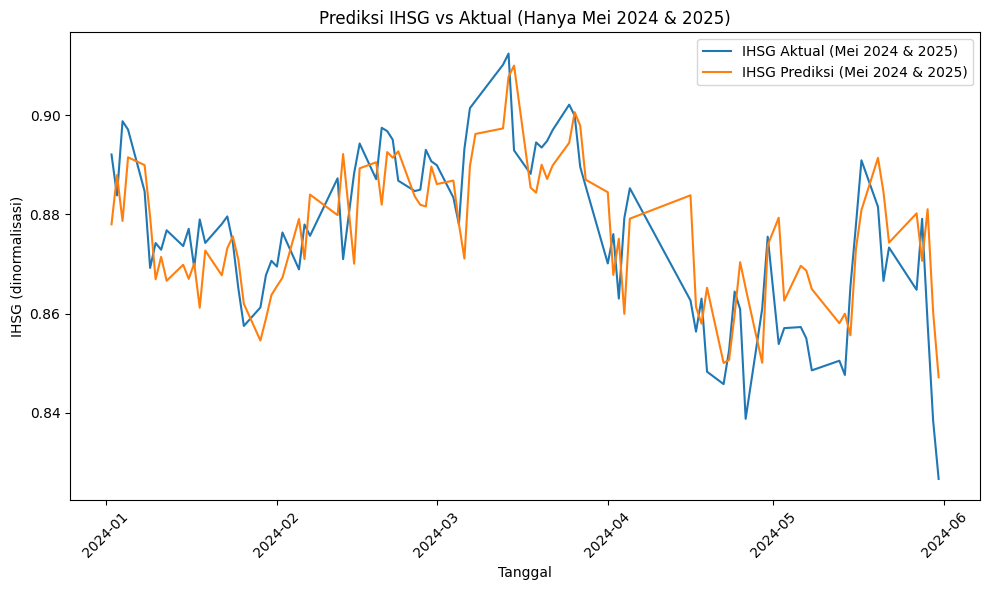

In [14]:
# Gabungkan ke dalam DataFrame agar mudah di‐slice per bulan
df_test = pd.DataFrame({
    'IHSG_Aktual':  y_test,
    'IHSG_Prediksi': y_pred
}, index=dates)
df_test.index.name = 'Tanggal'

# Ambil Mei 2024 dan Mei 2025
df_may_2024 = df_test.loc['2024-01-01':'2024-05-31']
df_may_2025 = df_test.loc['2025-05-01':'2025-05-31']
df_selected = pd.concat([df_may_2024, df_may_2025]).sort_index()

plt.figure(figsize=(10, 6))
plt.plot(df_selected.index, df_selected['IHSG_Aktual'], label='IHSG Aktual (Mei 2024 & 2025)')
plt.plot(df_selected.index, df_selected['IHSG_Prediksi'], label='IHSG Prediksi (Mei 2024 & 2025)')
plt.xlabel('Tanggal')
plt.ylabel('IHSG (dinormalisasi)')
plt.title('Prediksi IHSG vs Aktual (Hanya Mei 2024 & 2025)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()